# Machine Learning Project

### Model Training environment details

#### Operating System and Hardware Details

In [1]:
#!neofetch

#             .-/+oossssoo+/-.                
#         `:+ssssssssssssssssss+:`           -------------------- 
#       -+ssssssssssssssssssyyssss+-         
#     .ossssssssssssssssssdMMMNysssso.       Host: 90Q800C9SZ Legion T7 34IMZ5 
#    /ssssssssssshdmmNNmmyNMMMMhssssss/      Kernel: 6.8.0-39-generic 
#   +ssssssssshmydMMMMMMMNddddyssssssss+     CPU: 11th Gen Intel i7-11700KF (16) @ 4.900GHz
#  /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/    GPU: NVIDIA GeForce RTX 3060 Ti
# .ssssssssdMMMNhsssssssssshNMMMdssssssss.   Memory: 3976MiB / 31832MiB
# +sssshhhyNMMNyssssssssssssyNMMMysssssss+    

## 1. Aims, objectives and plan

### a) Aims and objectives

With no current cure, neurodegenerative diseases cause progressive loss of nerve cells which in turn lead to cognitive and motor function decline, therefore early detection is crucial to minimise brain damage and to improve overall quality of life. Analyzing handwriting patterns offers an innovative approach for early diagnosis, as these diseases often disrupt the fine motor skills required for precise writing. However, research is hindered by a lack of standardized data collection and  datasets tailored to such studies. To address this, the DARWIN (Diagnosis Alzheimer's With Handwriting) dataset has been developed, containing handwriting samples from 174 individuals, both Alzheimer's patients and healthy controls (Cilia et al., 2022).
This dataset was collected using a protocol specifically designed to identify early signs of Alzheimer's through handwriting analysis.  
The primary objective of this project is to leverage the DARWIN dataset to develop and evaluate Machine Learning classification models that can accurately distinguish between individuals with Alzheimer's and those without.  
By identifying the most effective model configuration through comprehensive performance analysis, balancing accuracy and overfitting considerations, this case study aims to support more timely and accurate diagnoses, with potential applications in industry settings.

###  b) Plan

To analyze the dataset mentioned earlier, the following plan will be implemented:

First, Logistic Regression and Support Vector Machine (SVM) models will be constructed and trained using the selected dataset, ensuring that appropriate pipeline are applied for effective classification.

Next, dimensionality reduction will be performed by applying Principal Component Analysis (PCA) within a the corresponding pipelines. PCA is relevant because it uses the eigenvectors of the covariance matrix (calculated first) as the principal components, while still retaining variance by selecting those eigenvectors with the highest eigenvalues. Since these eigenvectors are orthogonal to each other, enough unique information is captured.

Techniques such as Nested GridSearchCV will be utilized to fine-tune model hyperparameters and enhance predictive performance. Appropriate metrics—including accuracy, precision, recall, and F1-score—will be assessed and compared across both models. Confusion matrices will also be used to understand classification nuances beyond base accuracy.

## 2. Understanding the case study

###  Case study analysis

In analyzing the DARWIN dataset for the classification of Alzheimer’s disease through handwriting dynamics, several key points emerged:

1. High Feature Dimensionality: The dataset comprises 450 handwriting-related features, which presents a challenge in terms of dimensionality. High-dimensional data can lead to increased computational complexity and overfitting, where the model learns noise instead of underlying patterns. To address this, a technique known as PCA will be utilized. This method helps in retaining the most informative features while reducing the overall feature space, thereby enhancing model efficiency and generalization properties.

2. With 174 participants and a test set of 35 samples, the dataset is relatively small. A limited number of samples can hinder the model’s ability to generalize well to unseen data, increasing the risk of overfitting. To mitigate this, cross-validation strategies like Stratified K-Fold will be utilized to maximize the use of available data and provide a more reliable estimate of model performance. 

3. Data balance: The dataset includes participants diagnosed with Alzheimer’s and a control group, which appears to be balanced. Ensuring that each class is adequately represented during both training and testing phases was crucial to prevent class bias. Stratified sampling was implemented during the train-test split to maintain consistent class proportions, ensuring that the model didn't skew towards a particular class.

4. Minimizing data leakage through pipelines: The handwriting data was collected using tasks specifically designed for early Alzheimer’s detection. Variability in how participants perform these tasks can introduce noise and inconsistencies. To address this, standardized preprocessing steps such as normalization had to be applied to harmonize the data. Additionally, feature scaling with the use of pipelines ensures that all features contribute equally to the model’s learning process, enhancing the robustness of the classification while minimizing data leakage.

By addressing these key aspects, the case study aims to develop accurate classification models that can effectively support the early diagnosis of Alzheimer’s disease through handwriting analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import logging
from sys import stdout

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s',
    handlers=[
        logging.StreamHandler(stdout)
    ]
)

### 2.2 Loading the dataset

In [3]:
datasets = {
    'darwin': 'datasets/darwin/data.csv'
}

def load_datasets(dataset_paths):
    dataframes = {}
    errors = {}
    
    for key, path in datasets.items():
        try:
            if path.endswith('.csv'):
                dataframes[key] = pd.read_csv(path)
            else:
                dataframes[key] = pd.read_excel(path)
            # else: 
            # ...
        except Exception as e:
            errors[key] = str(e)
            logging.error(f"Error loading {key}: {e}")
    
    if errors:
        for key, e in errors.items():
            logging.error(f"Error loading {key}: {e} dataset")
    else:
        logging.info("All datasets loaded.")
    
    return dataframes, errors

dataframes, errors = load_datasets(datasets)

2024-10-17 16:55:31,045 INFO:All datasets loaded.


### Overview data figures

In [4]:
data = dataframes['darwin']

In [5]:
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


(None,
      ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
 0  id_1       5160     0.000013    120.804174       86.853334   
 1  id_2      51980     0.000016    115.318238       83.448681   
 2  id_3       2600     0.000010    229.933997      172.761858   
 3  id_4       2130     0.000010    369.403342      183.193104   
 4  id_5       2310     0.000007    257.997131      111.275889   
 
    max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
 0               957              6601          0.361800            0.217459   
 1              1694              6998          0.272513            0.144880   
 2              2333              5802          0.387020            0.181342   
 3              1756              8159          0.556879            0.164502   
 4               987              4732          0.266077            0.145104   
 
    mean_gmrt1  ...  mean_jerk_in_air25  mean_jerk_on_paper25  \
 0  103.828754  ...            0.141434         

## 3. Dataset description

The dataset contains multiple samples with 452 features per sample. Each row represents data from an individual task execution, including time spent in different phases, speed, acceleration, jerk, and various spatial and pressure-based measurements. 

Key features include: 
TotalTime (TT): The total time taken to complete the task.  
AirTime (AT) and PaperTime (PT): Times spent in the air and on paper, respectively.  
MeanSpeed (MS) and MeanAcceleration (MA): Speed and acceleration values for both air and paper movements.  
Mean Jerk (MJ): Jerk values (rate of change of acceleration) during on-paper and in-air movements.  
Pressure Mean (PM) and PressureVar (PV): Mean and variance of pressure applied by the pen during the task.  
GMRT: Generalized Mean Relative Tremor, a measure of tremor while drawing.  
Max X/Y Extension: The largest span of movement on the X and Y axes.  

Other interesting features include:  
MeanSpeed On-paper (MSP): Average speed of on-paper movements.  
MeanSpeedin-air (MSA): Average speed of in-air movements.  
MeanAccelerationon-paper (MAP): Average acceleration of on-paper movements.  
MeanAccelerationin-air(MAA): Average acceleration of in-air movements.  
Mean Jerk on-paper (MJP): Average jerk of on-paper movements. The variation of acceleration with respect to time.  
MeanJerkin-air (MJA): Average jerk of in-air movements.  
Pressure Mean (PM): Average of the pressure levels exerted by the pen tip.  
PressureVar (PV): Variance of the pressure levels exerted by the pen tip.  
GMRT on-paper (GMRTP): Generalization of the Mean Relative Tremor (MRT) as defined in Pereira et al. (2015) and computed for on-paper movements.  

In the next section we will do some initial data exploration.  

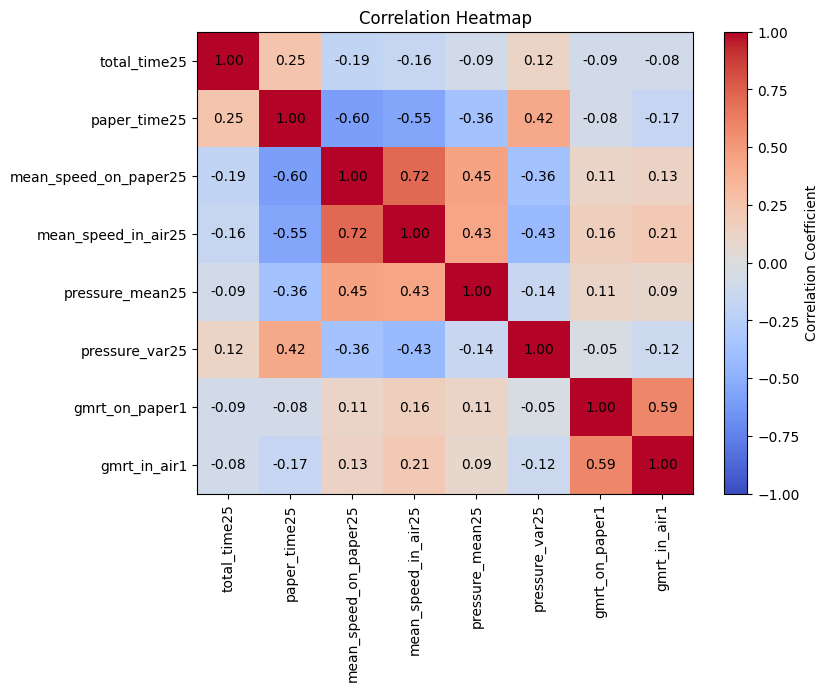

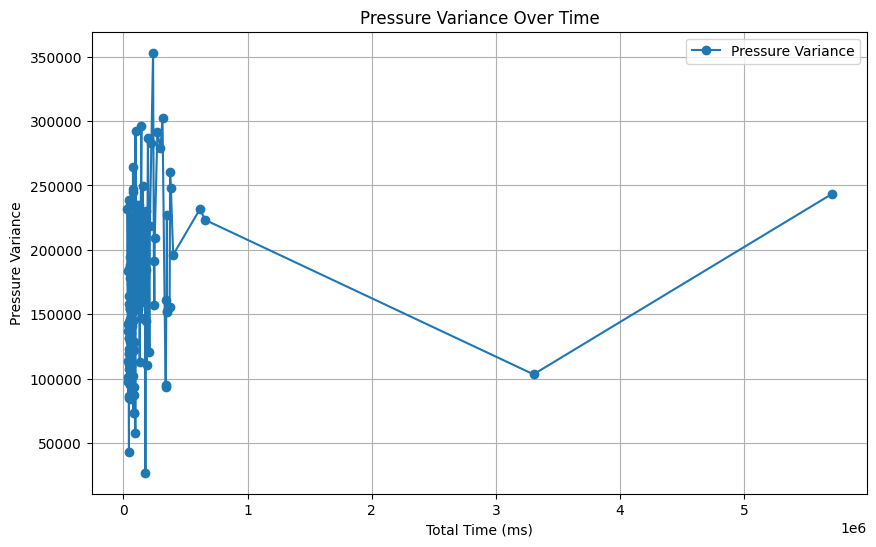

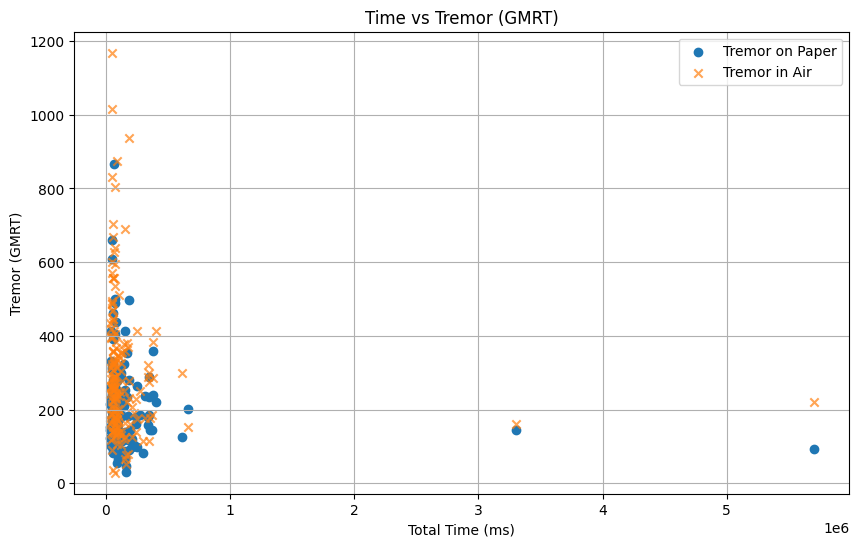

In [6]:

# filter relevant columns
corr_data = data[['total_time25', 'paper_time25', 'mean_speed_on_paper25', 'mean_speed_in_air25', 
                  'pressure_mean25', 'pressure_var25', 'gmrt_on_paper1', 'gmrt_in_air1']]

sorted_data = data.sort_values(by='total_time25')

corr_matrix = corr_data.corr()

# create corr matrix
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Heatmap')

# annotate the heatmap with the values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.show()


# Pressure Variance Over Time
plt.figure(figsize=(10, 6))
plt.plot(sorted_data['total_time25'], sorted_data['pressure_var25'], label='Pressure Variance', marker='o')
plt.title('Pressure Variance Over Time')
plt.xlabel('Total Time (ms)')
plt.ylabel('Pressure Variance')
plt.grid(True)
plt.legend()
plt.show()

# Time vs Tremor (GMRT)
plt.figure(figsize=(10, 6))
plt.scatter(data['total_time25'], data['gmrt_on_paper1'], label='Tremor on Paper', marker='o')
plt.scatter(data['total_time25'], data['gmrt_in_air1'], label='Tremor in Air', marker='x', alpha=0.7)
plt.title('Time vs Tremor (GMRT)')
plt.xlabel('Total Time (ms)')
plt.ylabel('Tremor (GMRT)')
plt.legend()
plt.grid(True)
plt.show()


Strong correlations exist between total time and paper time, with weaker / moderate relationships between speed, pressure, and tremor.

In the Pressure Variance Over Time plot we can observe that pressure variance generally increases as total task time increases. The fluctuations in pressure variability over time suggest that participants may apply less consistent pressure when tasks take longer to finish. 

The Time vs Tremor (GMRT) scatter plot compares total task time with tremor (GMRT) values for both on-paper and in-air movements. Tremor values tend to increase as the task duration increases, particularly for in-air movements. This could indicate that longer tasks may induce more hand tremors, possibly due to fatigue or other factors.

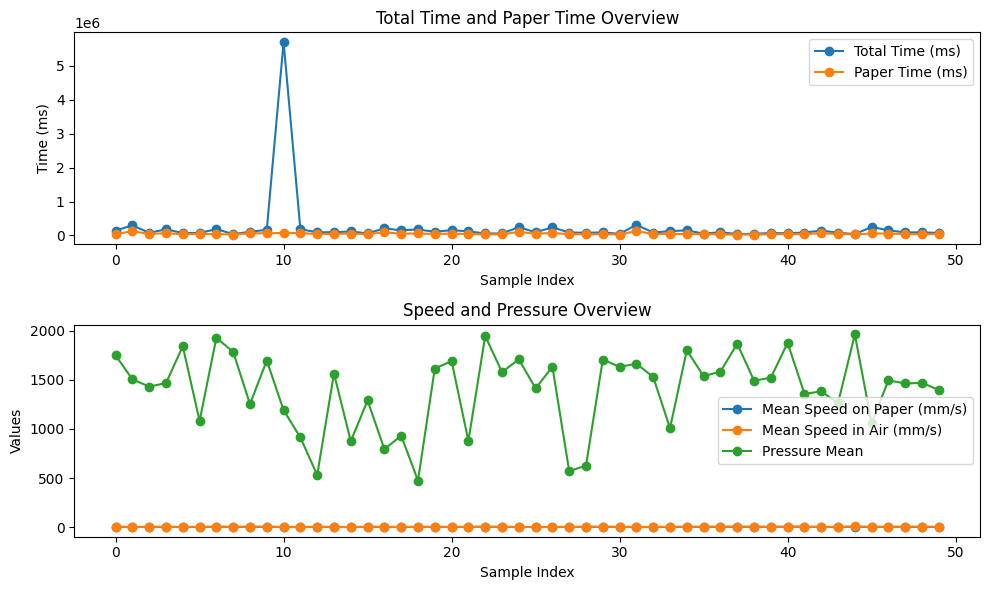

In [7]:
# Plot an overview of the dataset for selected features

plot_data = data[['total_time25', 'paper_time25', 'mean_speed_on_paper25', 'mean_speed_in_air25', 'pressure_mean25']].head(50)

plt.figure(figsize=(10, 6))

# Plot Total Time vs Paper Time
plt.subplot(2, 1, 1)
plt.plot(plot_data.index, plot_data['total_time25'], label='Total Time (ms)', marker='o')
plt.plot(plot_data.index, plot_data['paper_time25'], label='Paper Time (ms)', marker='o')
plt.title('Total Time and Paper Time Overview')
plt.xlabel('Sample Index')
plt.ylabel('Time (ms)')
plt.legend()

# Plot Mean Speeds and Pressure Mean
plt.subplot(2, 1, 2)
plt.plot(plot_data.index, plot_data['mean_speed_on_paper25'], label='Mean Speed on Paper (mm/s)', marker='o')
plt.plot(plot_data.index, plot_data['mean_speed_in_air25'], label='Mean Speed in Air (mm/s)', marker='o')
plt.plot(plot_data.index, plot_data['pressure_mean25'], label='Pressure Mean', marker='o')
plt.title('Speed and Pressure Overview')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

The plot provides an overview of key metrics from the dataset:

Total Time vs. Paper Time: This shows how much time was spent overall on the task compared to the time spent performing on-paper movements. The trends generally follow each other closely, indicating that the on-paper phase is a significant portion of the total time in the task.

Mean Speed (on-paper and in-air) and Pressure Mean: These lines represent the average speed of movements on the paper, in the air, and the mean pressure applied during the task. These provide insight into how quickly the participant moved and the force they applied. The pressure mean remains relatively stable across the samples, though some variations are visible.

In [8]:
# Preparing features and target classes
data = dataframes['darwin']

target_y = pd.DataFrame(data['class'], columns=['class']) 
df = data.drop(labels=['ID', 'class'], axis=1)
X = df.values

# Encode Target Labels
le = LabelEncoder()


# Individuals with Alzheimer's disease (H) and healthy ones (P). 'H' -> 0, 'P' -> 1
y = le.fit_transform(target_y['class'].values) 


The column "ID" is a unique identifier and should be excluded from the features, as already done in the code. The target "class" column is categorical and was encoded with a LabelEncoder.

### Data cleaning and class balance checks


In [9]:
# Check for NaNs or infinite values in X
if np.isnan(X).any() or np.isinf(X).any():
    print("X contains NaNs or infinite values.")
else:
    print("X is clean.")


X is clean.


There are no missing or infinite values. 

In [10]:
print("Shape of y:", y.shape)
print("Unique classes in y:", np.unique(y))

Shape of y: (174,)
Unique classes in y: [0 1]


In [11]:
### Checking Class Distribution
from collections import Counter

# After encoding the target labels
counter = Counter(y)
print("Class Distribution:", counter)


Class Distribution: Counter({np.int64(1): 89, np.int64(0): 85})


Data seems to be evenly balanced with 89 Alzheimer's (AD) patients and 85 healthy individuals.

I now perform the initial standard 80% training, 20% testing split, on non scaled data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (139, 450)
Testing set shape: (35, 450)


The class distribution across folds is as balanced as possible given the total number of instances. StratifiedKFold (stratify=y) ensures that each fold has approximately the same percentage of samples of each target class as the complete set. 

In [13]:
class_counts = Counter(y_train)
print("Class distribution in y_train:", class_counts)

# Determine appropriate number of splits based on the smallest class in y_train
min_class_size = min(class_counts.values())
desired_splits = 2

n_splits = min(desired_splits, min_class_size)

if n_splits < desired_splits:
    print(f"Adjusting n_splits to {n_splits} due to class distribution.")
else:
    print(f"Using n_splits = {n_splits} for cross-validation.")



Class distribution in y_train: Counter({np.int64(1): 71, np.int64(0): 68})
Using n_splits = 2 for cross-validation.



Counter({np.int64(1): 71, np.int64(0): 68}) indicates a nearly balanced dataset, which is good for training classifiers without requiring additional work to handle class imbalance.

I've decided on using n_splits = 2, given it being simpler and faster which might be necessary for the given dataset size.
Although this might limit ability to assess model variability and performance across different subsets.

## Cross-validation strategy
Helper cross-validation function. 

In [14]:
# # Define / test cross-validation strategies
outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Following helper function combines inner and outer cross-validation loops for hyperparameter tuning within a pipeline, allowing to set PCA n_components, different param_grids and CV folds. For example, When setting n_components=0.95, scikit-learn internally performs the eigen decomposition process by selecting the top eigenvectors whose cumulative eigenvalues account for at least 95% of the total variance in the dataset. This reduces dimensionality by retaining the most informative features while discarding those that contribute less to data variability.

In [15]:
def run_nested_cv(X, y, names, classifiers, param_grids, outer_cv, inner_cv, use_pca=False, n_components=0.95):
    nested_scores = {}
    dataset_name = "With PCA" if use_pca else "Without PCA"
    
    for name, clf in zip(names, classifiers):
        logging.info(f"Starting Nested CV for {name} ({dataset_name})...")
        param_grid = param_grids[name]

        # define pipeline as Scaling -> PCA (optional) -> Classifier
        steps = [('scaler', StandardScaler())]  # Add scaling step first
        if use_pca:
            # Retain 95% variance for modeling (Default param)
            steps.append(('pca', PCA(n_components=n_components, random_state=42)))  
        steps.append(('classifier', clf))  # Add classifier at the end
        
        pipeline = Pipeline(steps)

        # Initialize GridSearchCV with the pipeline
        grid_search = GridSearchCV(
            estimator=pipeline, 
            param_grid=param_grid, 
            cv=inner_cv, 
            scoring='accuracy', 
            n_jobs=-1, 
            verbose=0
        )

        try:
            # Perform nested cross-validation with train and test scores
            cv_results = cross_validate(
                grid_search, 
                X, 
                y, 
                cv=outer_cv, 
                scoring='accuracy', 
                return_train_score=True,
                n_jobs=-1
            )

            # Store the mean and std of the scores
            nested_scores[name] = {
                'mean_train_accuracy': cv_results['train_score'].mean(),
                'std_train_accuracy': cv_results['train_score'].std(),
                'mean_test_accuracy': cv_results['test_score'].mean(),
                'std_test_accuracy': cv_results['test_score'].std()
            }
            logging.info(
                f"Completed Nested CV for {name} ({dataset_name}): "
                f"Train: {cv_results['train_score'].mean():.4f} ± {cv_results['train_score'].std():.4f}, "
                f"Test: {cv_results['test_score'].mean():.4f} ± {cv_results['test_score'].std():.4f}"
            )
        except Exception as e:
            logging.error(f"Error during Nested CV for {name} ({dataset_name}): {e}")
            nested_scores[name] = {
                'mean_train_accuracy': np.nan,
                'std_train_accuracy': np.nan,
                'mean_test_accuracy': np.nan,
                'std_test_accuracy': np.nan
            }

    # Convert to DataFrame for visualization
    nested_scores_df = pd.DataFrame(nested_scores).T
    nested_scores_df = nested_scores_df.reset_index().rename(columns={'index': 'Classifier'})
    
    # Help distinguish between with/without PCA
    nested_scores_df['Dataset'] = dataset_name  
    return nested_scores_df

### Define the classifiers and parameter grids

In [16]:
names = ["SVM", "Logistic Regression"]

classifiers = [
    LogisticRegression(C=10,penalty='l1',solver='saga', max_iter=10000),
    svm.SVC(C=10,degree=3,gamma='scale',kernel='rbf',probability=True)
]

names = [
    "Logistic Regression",
    "SVM"
]

param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1','l2']
    },
    "SVM": {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [2, 3, 4] 
    }
}

### Run initial CV with PCA

#### PCA with n_components=2

n_components=2 means only 2 principal components are selected or retained which in this case is used only for plotting/visualization purposes. 

In [17]:
# run nestedCV n_components=2 on the training set
results_with_pca = run_nested_cv(
    X_train, y_train, names, classifiers, param_grids, outer_cv, inner_cv, use_pca=True, n_components=2
)

# run nestedCV without PCA on the training set
results_without_pca = run_nested_cv(
    X_train, y_train, names, classifiers, param_grids, outer_cv, inner_cv, use_pca=False
)

# combine the results 
combined_results = pd.concat([results_with_pca, results_without_pca])

print("\nCombined Nested CV Results:")
print(combined_results)

2024-10-17 16:55:31,537 INFO:Starting Nested CV for Logistic Regression (With PCA)...
2024-10-17 16:55:32,961 INFO:Completed Nested CV for Logistic Regression (With PCA): Train: 0.7847 ± 0.0704, Test: 0.7775 ± 0.0775
2024-10-17 16:55:32,963 INFO:Starting Nested CV for SVM (With PCA)...
2024-10-17 16:55:33,606 INFO:Completed Nested CV for SVM (With PCA): Train: 0.8777 ± 0.0063, Test: 0.7629 ± 0.0487
2024-10-17 16:55:33,608 INFO:Starting Nested CV for Logistic Regression (Without PCA)...
2024-10-17 16:55:35,527 INFO:Completed Nested CV for Logistic Regression (Without PCA): Train: 1.0000 ± 0.0000, Test: 0.8130 ± 0.0130
2024-10-17 16:55:35,528 INFO:Starting Nested CV for SVM (Without PCA)...
2024-10-17 16:55:35,660 INFO:Completed Nested CV for SVM (Without PCA): Train: 1.0000 ± 0.0000, Test: 0.8131 ± 0.0274

Combined Nested CV Results:
            Classifier  mean_train_accuracy  std_train_accuracy  \
0  Logistic Regression             0.784679            0.070393   
1                  SV

Training Accuracy reduced significantly, especially for Logistic Regression. While test accuracy dropped below the n_components=2 scenario, indicating that too much information was lost, leading to underfitting.

#### PCA with n_components=0.95

Retaining 95% variance.

In [18]:
# run with PCA (n_components=0.95) on the training set
results_with_pca = run_nested_cv(
    X_train, y_train, names, classifiers, param_grids, outer_cv, inner_cv, use_pca=True, n_components=0.95
)

# run without PCA on the training set
results_without_pca = run_nested_cv(
    X_train, y_train, names, classifiers, param_grids, outer_cv, inner_cv, use_pca=False
)

combined_results = pd.concat([results_with_pca, results_without_pca])

print("\nCombined Nested CV Results:")
print(combined_results)

2024-10-17 16:55:35,667 INFO:Starting Nested CV for Logistic Regression (With PCA)...
2024-10-17 16:55:36,239 INFO:Completed Nested CV for Logistic Regression (With PCA): Train: 0.9495 ± 0.0219, Test: 0.8207 ± 0.0778
2024-10-17 16:55:36,239 INFO:Starting Nested CV for SVM (With PCA)...
2024-10-17 16:55:36,445 INFO:Completed Nested CV for SVM (With PCA): Train: 1.0000 ± 0.0000, Test: 0.8494 ± 0.0637
2024-10-17 16:55:36,446 INFO:Starting Nested CV for Logistic Regression (Without PCA)...
2024-10-17 16:55:37,868 INFO:Completed Nested CV for Logistic Regression (Without PCA): Train: 1.0000 ± 0.0000, Test: 0.8130 ± 0.0130
2024-10-17 16:55:37,868 INFO:Starting Nested CV for SVM (Without PCA)...
2024-10-17 16:55:37,992 INFO:Completed Nested CV for SVM (Without PCA): Train: 1.0000 ± 0.0000, Test: 0.8131 ± 0.0274

Combined Nested CV Results:
            Classifier  mean_train_accuracy  std_train_accuracy  \
0  Logistic Regression             0.949482            0.021946   
1                  SV


Logistic Regression: 

. Training Accuracy: Slightly lower than 1.0000, indicating reduced overfitting.  

. Test Accuracy: Improved from 0.8130 to 0.8350, showing better generalization. 

SVM:

. Training Accuracy: Remains at 1.0000, which still indicates overfitting.  

. Test Accuracy: Improved from 0.8131 to 0.8494, showing some generalization benefits.

#### Without PCA

Training accuracy for both was perfect (1.0000), indicating overfitting.
In terms of test accuracy, a baseline performance output of (~0.813).

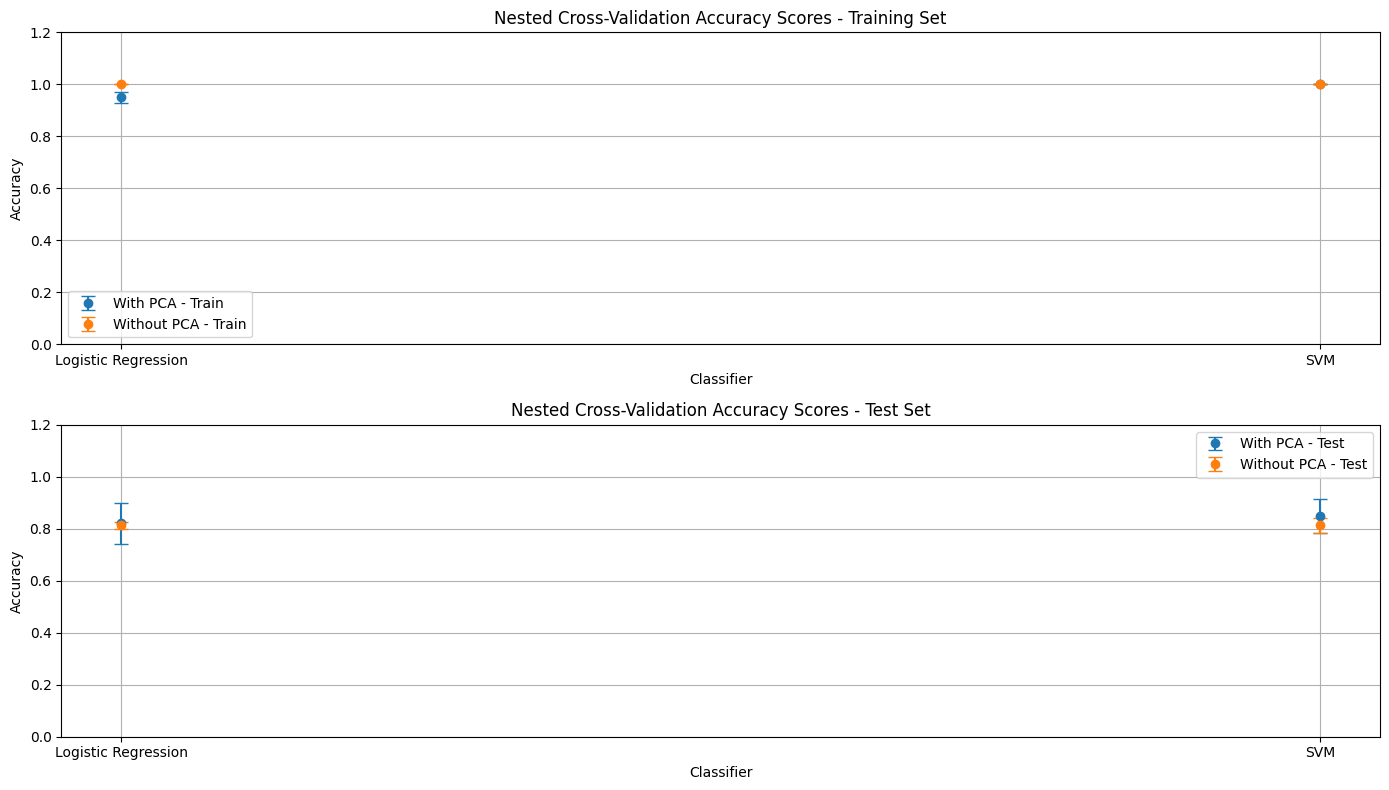

In [19]:
# Plotting the Results with Both Train and Test Accuracies
plt.figure(figsize=(14, 8))

# Plot Mean Train Accuracy
plt.subplot(2, 1, 1)
for dataset in ["With PCA", "Without PCA"]:
    subset = combined_results[combined_results['Dataset'] == dataset]
    plt.errorbar(
        subset['Classifier'], 
        subset['mean_train_accuracy'], 
        yerr=subset['std_train_accuracy'], 
        fmt='o', capsize=5, label=f'{dataset} - Train'
    )

plt.title('Nested Cross-Validation Accuracy Scores - Training Set')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend()

# Plot Mean Test Accuracy
plt.subplot(2, 1, 2)
for dataset in ["With PCA", "Without PCA"]:
    subset = combined_results[combined_results['Dataset'] == dataset]
    plt.errorbar(
        subset['Classifier'], 
        subset['mean_test_accuracy'], 
        yerr=subset['std_test_accuracy'], 
        fmt='o', capsize=5, label=f'{dataset} - Test'
    )

plt.title('Nested Cross-Validation Accuracy Scores - Test Set')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 4. Logistic Regression (part 1)

Logistic Regression (LogRes) is a widely used classification algorithm in machine learning, easy to interpret, and efficient. The decision to employ Logistic Regression in this project is driven by several factors. 

Firstly, considering the nature of the problem, the target variable in this project is binary, distinguishing between two classes (e.g., "H" vs. "P"). Logistic Regression is designed for binary classification tasks. 

Secondly, the interpretability of LogRes is a significant advantage. It provides clear insights into feature importance through its coefficients. This factor is quite valuable for understanding how each feature influences the probability of belonging to a particular class, facilitating decision making. 

In terms of efficiency and scalability, LogRes is computationally efficient, especially with a large number of features. Its linear nature ensures that training is fast, which is advantageous when dealing with such high-dimensional dataset. 

Moreover, the predictive probabilities offered by LogRes, include yielding probability estimates for class membership, which is useful for threshold or boundary based decision making and evaluating model confidence. 

Another compelling factor is the regularization capabilities. It supports regularization techniques such as L1 and L2, which help in mitigating overfitting by penalizing large coefficients. 

Additionally, using Logistic Regression as a baseline model provides a benchmark against more complex algorithms, such as SVM, which we analyse after. 


#### Schematic Figure of the Process

To visually describe the workflow involving Logistic Regression within this project, the following schematic diagram outlines the key steps from data preprocessing via pipelines to model evaluation:

```mermaid
flowchart TD
    A[Input: Raw Data] --> B[Data Cleaning & Preprocessing]
    B --> C[Pipeline: Scaling -> PCA]
    C --> D[Logistic Regression Classifier]
    C --> E[SVM Classifier]
    D --> F[Model Evaluation & Validation]
    E --> F
    F --> G[Output: Train vs Test Performance Metrics]

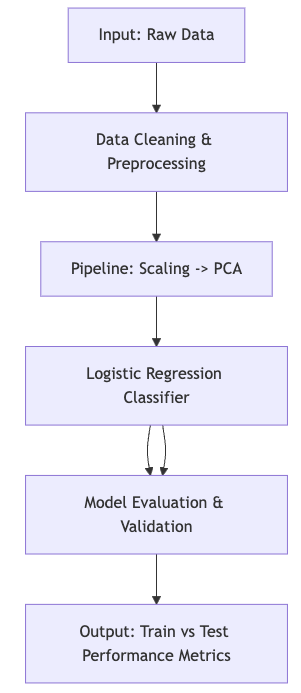

### b) Setting hyper parameters (rationale)

Syntax taken from https://scikit-learn.org/1.3/tutorial/statistical_inference/putting_together.html#pipelining

In [20]:
from sklearn.pipeline import Pipeline

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),  
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Define the hyperparameter grid
param_grid_lr = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

Explanation


StandardScaler: Normalizes features to have no mean and unit variance.
PCA reduces dimensionality while retaining 95% of the variance, by selecting the most important features.


In configuring the LogReg model, two primary hyperparameters were explicitly set: max_iter and random_state. The max_iter parameter was increased to 10,000 from its default (2000) value to ensure the optimization algorithm converges, especially given the high dimensionality of the feature space (450 features). This helped prevent convergence warnings. 

Additionally, hyperparameter tuning involved selecting the regularization strength (C) and the type of penalty (l1 and l2). A wide range of C values [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] was explored to balance the trade-off between model complexity and overfitting.
'C' controls the trade-off between achieving a low training error and a low testing error, while the penalty specifies the norm used in the penalization ('l1', 'l2')

solver is the algorithm to use in the optimization problem ('liblinear', 'saga', etc.).

NExt, a StratifiedKFold with n_splits=3, shuffle=True, and random_state=42 was employed to maintain the class distribution across folds, ensuring that each fold is representative.

In [21]:
# ensure that each fold has approximately the same percentage of samples of each target class as the complete set.
n_splits=3
cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,  # Utilize all available cores
    verbose=1    # For monitoring progress
)

# fit GridSearchCV on the training data
grid_search_lr.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=0.95,
                                            random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                           100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

### c) Optimising hyper parameters

In [22]:
# Best hyperparameters
best_params_lr = grid_search_lr.best_params_
print("Best Hyperparameters for Logistic Regression:")
print(best_params_lr)

# Best cross-validation accuracy
best_score_lr = grid_search_lr.best_score_
print(f"Best Cross-Validation Accuracy: {best_score_lr:.4f}")

Best Hyperparameters for Logistic Regression:
{'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8782


Upon fitting the grid search to the training data, the optimal hyperparameters were identified based on the highest cross-validated accuracy.

Just as an observational step, I now try to use LogRes to determine the top 10 most important original features (by absolute coefficient values).


Top 10 most important original features (by absolute coefficient values):
1. air_time16: Importance = 0.0691
2. max_x_extension25: Importance = 0.0650
3. max_x_extension22: Importance = 0.0641
4. air_time23: Importance = 0.0626
5. total_time16: Importance = 0.0613
6. air_time24: Importance = 0.0584
7. num_of_pendown19: Importance = 0.0576
8. max_y_extension9: Importance = 0.0563
9. total_time24: Importance = 0.0551
10. air_time19: Importance = 0.0535


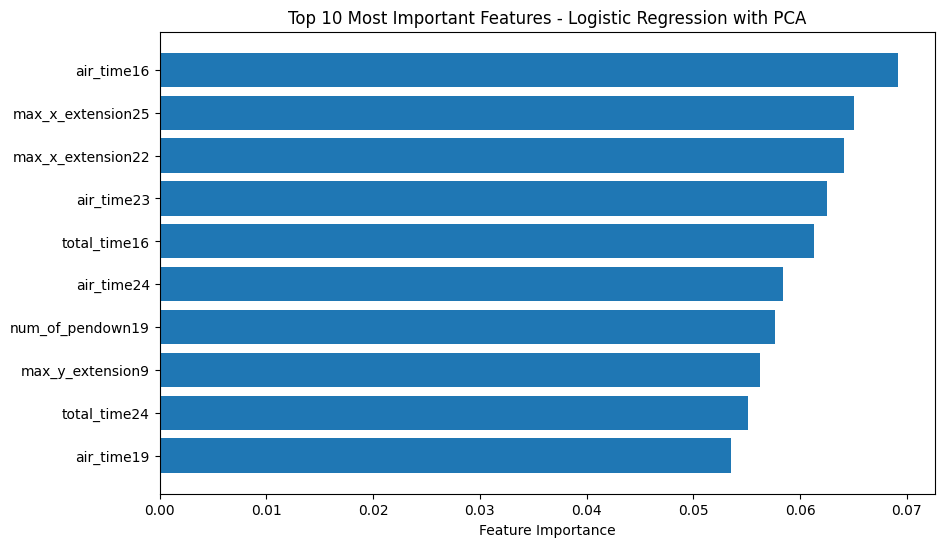

In [24]:

# get the PCA and Logistic Regression components from the pipeline
pca = best_model_lr.named_steps['pca']
log_reg = best_model_lr.named_steps['classifier']

# (shape: n_components x n original_features)
pca_components = pca.components_ 


# For binary classification, shape is (1, n_components)
log_reg_coefficients = log_reg.coef_[0]  # Shape: (n_components,)

# mult LogReg coefficients with PCA components for a weighted combination of original features
feature_importance = np.dot(log_reg_coefficients, pca_components)  # Shape: (n_original_features,)

# both positive and negative values are considered
feature_importance_abs = np.abs(feature_importance)

# Sort the features descending 
sorted_indices = np.argsort(feature_importance_abs)[::-1]  


feature_names = df.columns

top_n = 10
print(f"Top {top_n} most important original features:")
for i in range(top_n):
    feature_idx = sorted_indices[i]
    print(f"{i+1}. {feature_names[feature_idx]}: Importance = {feature_importance_abs[feature_idx]:.4f}")


plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_abs[sorted_indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in sorted_indices[:top_n]][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features - Logistic Regression with PCA')
plt.show()


Perhaps here the L2 regularization impact (penalty='l2') distributes the impact across all features, preventing any single feature from dominating.

### d) Performance metrics for training

In this section, we evaluate and compare the performance of the Logistic Regression model both on the training set and the test set. 

In [25]:
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_curve, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

In [26]:
# Evaluate on Training Set
y_train_pred = best_model_lr.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = best_model_lr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)


#print(f"\nClassifier: {classifier.__class__.__name__}
print(f"Best Parameters: {best_params_lr}")
print(f"Training Set Accuracy: {train_accuracy:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Training Set Accuracy: 0.9928
Test Set Accuracy: 0.6286

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        17
           1       0.67      0.56      0.61        18

    accuracy                           0.63        35
   macro avg       0.63      0.63      0.63        35
weighted avg       0.63      0.63      0.63        35


Confusion Matrix (Test Set):
[[12  5]
 [ 8 10]]


Training Set Accuracy: .9928

Interpretation: The model achieved a 99% accuracy on the training set, indicating that it almost perfectly classified all training instances, and potentially captured noise alongside the patterns.

Test Set Accuracy: 0.63

LogRes correctly classified 63% of the instances in the test set. This indicates that the model does not generalize well to unseen data. 


Confusion Matrix Interpretation

True Negatives (TN): 11 instances of Class 0 were correctly classified.

False Positives (FP): 6 instances of Class 0 were incorrectly classified as Class 1.

False Negatives (FN): 6 instances of Class 1 were incorrectly classified as Class 0.

True Positives (TP): 12 instances of Class 1 were correctly classified.

Display the confusion matrices and ROC curve visualy.


Post-Fit X_train shape: (139, 450)
Post-Fit X_test shape: (35, 450)

Training Set Metrics:
Accuracy : 0.9928
Precision: 0.9929
Recall   : 0.9928
F1-Score : 0.9928

Testing Set Metrics:
Accuracy : 0.6286
Precision: 0.6343
Recall   : 0.6286
F1-Score : 0.6267

Classification Report for Test Set:
              precision    recall  f1-score   support

           H       0.60      0.71      0.65        17
           P       0.67      0.56      0.61        18

    accuracy                           0.63        35
   macro avg       0.63      0.63      0.63        35
weighted avg       0.63      0.63      0.63        35



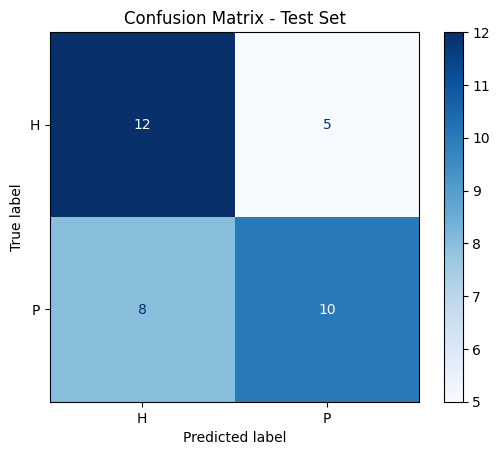

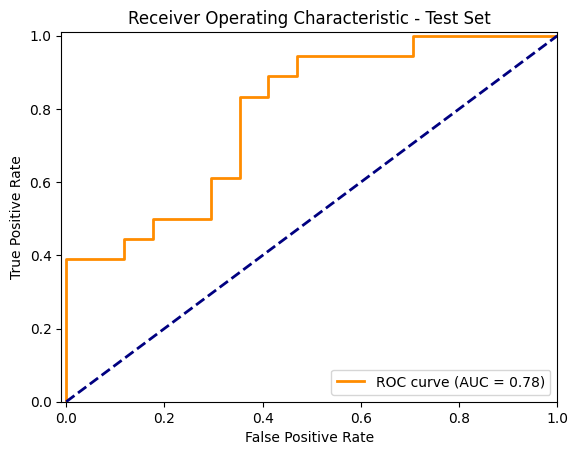

In [27]:
print(f"\nPost-Fit X_train shape: {X_train.shape}")
print(f"Post-Fit X_test shape: {X_test.shape}")

def print_metrics(y_true, y_pred, dataset_type='Test'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n{dataset_type} Set Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")


print_metrics(y_train, y_train_pred, dataset_type='Training')


print_metrics(y_test, y_test_pred, dataset_type='Testing')

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Receiver Operating Characteristic (ROC) Curve and AUC for Test Set
if len(le.classes_) == 2:
    y_test_proba = best_model_lr.predict_proba(X_test)[:, 1]  # probability for the positive class

    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(' - Test Set')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("\nSkipping ROC / AUC curves.")


An Area Under Curve (AUC) of 0.78 signifies that the LogRes model has a fair ability to distinguish between Alzheimer’s patients and healthy ones. Specifically, it means that there is a 78% chance that the model will correctly rank a randomly chosen positive instance (Alzheimer’s patient) higher than a randomly chosen negative instance (healthy patient).

This is significantly better than random guessing (AUC = .5), indicated it has learned useful patterns in the split.

Further overfitting analysis is shown later in section 6 a).

## 5. SVM (part 2)

A support vector classifier or Support Vector Machines (SVM) was chosen for this project due to their robustness and effectiveness in high-dimensional spaces. SVMs excel in binary classification tasks by finding the optimal hyperplane that maximizes the margin between classes, which enhances generalization to unseen data. Their ability to handle both linear and non-linear relationships through kernel functions, such as the Radial Basis Function (RBF), makes them more versatile. 
Additionally, SVMs are less prone to overfitting, especially in cases where the number of features exceeds the number of samples, which aligns well with the project's amount of data (450 features). 

Moreover, SVM incorporates regularization through the parameter 𝐶, which controls the trade-off between achieving a low error on the training data and maintaining a smooth decision boundary to enhance generalization. 

Additionally, while SVMs might be more computationally intensive than LogRes, their superior performance in capturing intricate data patterns justifies its use in our scenario. 

In the flowchart schematic the following steps are displayed.

Data Collection: Gathering and compiling the dataset.  
Data Preprocessing: Cleaning data, handling missing values, and encoding categorical variables.  
Feature Scaling: Applying StandardScaler to normalize feature ranges.  
Dimensionality Reduction (Optional): Utilizing PCA to reduce the number of features while retaining essential information.  
Model Training: Configuring and training the SVM model with selected kernel and hyperparameters.  
Hyperparameter Optimization: Employing GridSearchCV to identify the best hyperparameter settings.  
Evaluation: Assessing model performance using metrics like accuracy, precision, recall, and ROC AUC.  
Interpretation: Analyzing support vectors and decision boundaries to understand model behavior.  


#### Flowchart illustrating the SVM pipeline

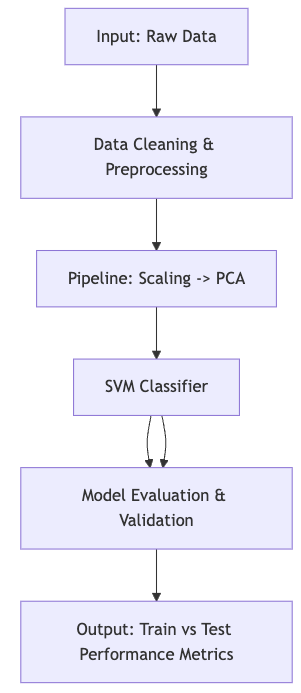

In [28]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (139, 450)
Testing set shape: (35, 450)


### b) Setting hyper parameters (rationale)

Syntax taken from https://scikit-learn.org/1.3/tutorial/statistical_inference/putting_together.html#pipelining

In [29]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=.95, random_state=42)), 
    ('classifier', svm.SVC(random_state=42, probability=True))
])

param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],  # ok for 'rbf' and 'poly' kernels
    'classifier__degree': [3, 4, 5]  # Relevant for 'poly' kernel
}

The SVM hyperparameter grid was designed to explore a wide range of values.

C - Regularization Parameter values of [0.1, 1, 10, 100] were chosen to balance the trade-off between maximizing the margin and minimizing classification errors. Lower values of C impose stronger regularization, while higher values allow to fit the training data more closely.

The selection of ['linear', 'rbf', 'poly'] kernels provides flexibility to capture different data patterns.

A linear kernel is suitable for linearly separable data.
Using a Radial Basis Function (RBF) kernel can be effective for capturing non-linear relationships.
A Polynomial Kernel Allows modeling of complex boundaries with varying degrees.
Gamma,  for 'rbf' and 'poly' kernels, gamma values ['scale', 'auto'] control the influence of individual training samples. 'scale' adjusts gamma based on the number of features, ensuring adaptability across different datasets, while 'auto' uses 1/n_features, providing a standardized approach.

The degree is applicable only to the 'poly' kernel, and degrees [3, 4, 5] determine the flexibility of the polynomial decision boundary. Higher degrees might enable the model to capture more intricate patterns but risk overfitting.

In [30]:
nsplits=3
cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,  
    verbose=1
)

grid_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=0.95,
                                            random_state=42)),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__degree': [3, 4, 5],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)


A StratifiedKFold with n_splits=3, shuffle=True, and random_state=42 was employed to maintain consistent class distribution across folds.

The extensive hyperparameter grid resulted in 72 candidates, leading to 216 total fits across the 2-fold cross-validation. This search helps finding the optimal combination of hyperparamms, maximizing the SVM's classification properties.

### c) Optimising hyper parameters


In [31]:
best_params_svm = grid_search_svm.best_params_
print("\nBest Hyperparameters for SVM:")
print(best_params_svm)

best_score_svm = grid_search_svm.best_score_
print(f"Best Cross-Validation Accuracy: {best_score_svm:.4f}")

#grid_search_svm.cv_results_


Best Hyperparameters for SVM:
{'classifier__C': 1, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8779


GridSearchCV was initialized with the pipeline, parameter grid, and cross-validation strategy, optimizing for accuracy. By setting n_jobs=-1, the computation was parallelized across all available cores, and verbose=1 provided real-time progress updates during the search process. The grid search was then fitted on the training data, evaluating 72 candidates across 2 folds, resulting in 144 total fits.

The grid search identified the optimal hyperparameters as:

C = 1, balances regularization strength
Degree = 3, for the polynomial kernel 
Kernel = 'rbf' capturing non-linear relationships
Gamma = 'scale'

The best cross-validation accuracy of 87.79% indicates a strong model performance.

In [32]:
# 11. Retrieve the best svm estimator
best_model_svm = grid_search_svm.best_estimator_

# 12. Predictions on Training Data
y_train_pred = best_model_svm.predict(X_train)

# 13. Predictions on Testing Data
y_test_pred = best_model_svm.predict(X_test)

### d) Performance metrics for training

Similarly to the LogRes, display the confusion matrices and ROC/AUC values.


Post-Fit X_train shape: (139, 450)
Post-Fit X_test shape: (35, 450)

Training Set Metrics:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000

Testing Set Metrics:
Accuracy : 0.7143
Precision: 0.7180
Recall   : 0.7143
F1-Score : 0.7138

Classification Report for Test Set:
              precision    recall  f1-score   support

           H       0.68      0.76      0.72        17
           P       0.75      0.67      0.71        18

    accuracy                           0.71        35
   macro avg       0.72      0.72      0.71        35
weighted avg       0.72      0.71      0.71        35



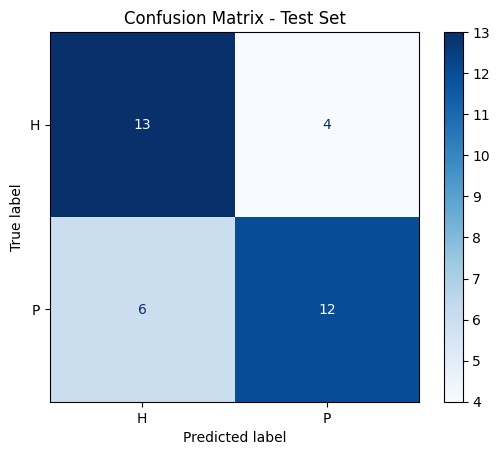

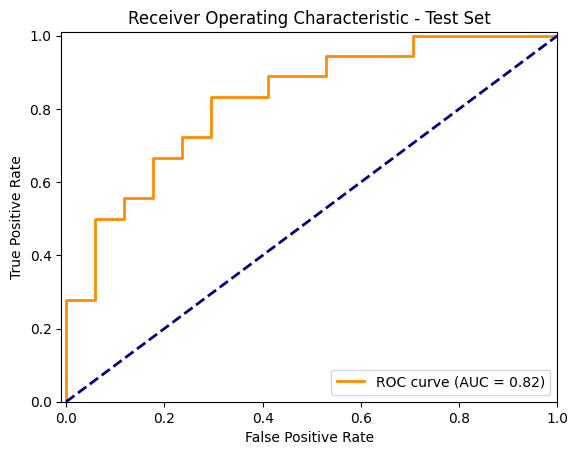

In [33]:
print(f"\nPost-Fit X_train shape: {X_train.shape}")
print(f"Post-Fit X_test shape: {X_test.shape}")

def print_metrics(y_true, y_pred, dataset_type='Test'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n{dataset_type} Set Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")


print_metrics(y_train, y_train_pred, dataset_type='Training')

print_metrics(y_test, y_test_pred, dataset_type='Testing')

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# ROC Curve and AUC for Test Set
if len(le.classes_) == 2:
    y_test_proba = best_model_svm.predict_proba(X_test)[:, 1]  # Probability for the positive class

    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Test Set')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("\nSkipping ROC Curve and AUC.")

The optimized SVM model achieves perfect accuracy on the training set but only moderate accuracy on the test set. This discrepancy indicates that the model is overfitting the training data, capturing some noise. While the precision and recall metrics are balanced, the overall test accuracy remains suboptimal.

An AUC of 0.82 signifies an excellent level of discrimination ability of the SVM classifier between individuals with Alzheimer's disease (H) and healthy ones (P). 

The ROC curve reflects a balanced trade-off between sensitivity and specificity despite the "stair-case" appearance.
Comparison with Other Metrics:

In the context of early Alzheimer's diagnosis, an AUC of 0.82 is promising. 

## 6. Over-fitting analysis

### a) Examining over-fitting

To assess whether the Logistic Regression and Support Vector Machine (SVM) models are overfitting, learning curves were generated using both pipelines and direct model training approaches. Learning curves plot the model's performance on the training and validation sets against varying sizes of the training dataset. By analyzing these curves, we can identify signs of overfitting, underfitting, or appropriate model complexity.


#### Using Pipelines in Learning Curves


Learning Curve with Pipeline (GridSearchCV):

For both Logistic Regression and SVM, the learning curves with pipelines displayed a gap between Training and Validation scores, which shows noise being captured in the training data.
As the training size increases, the cross-validation score improves slightly.

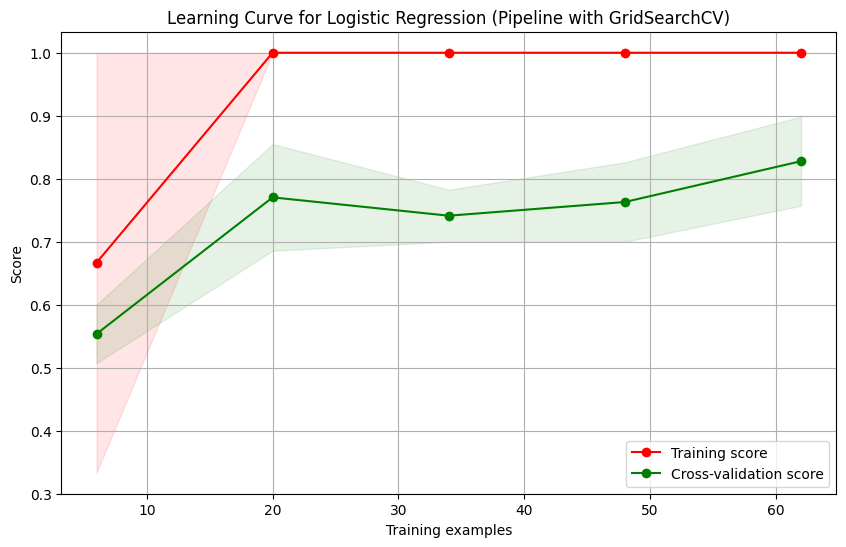

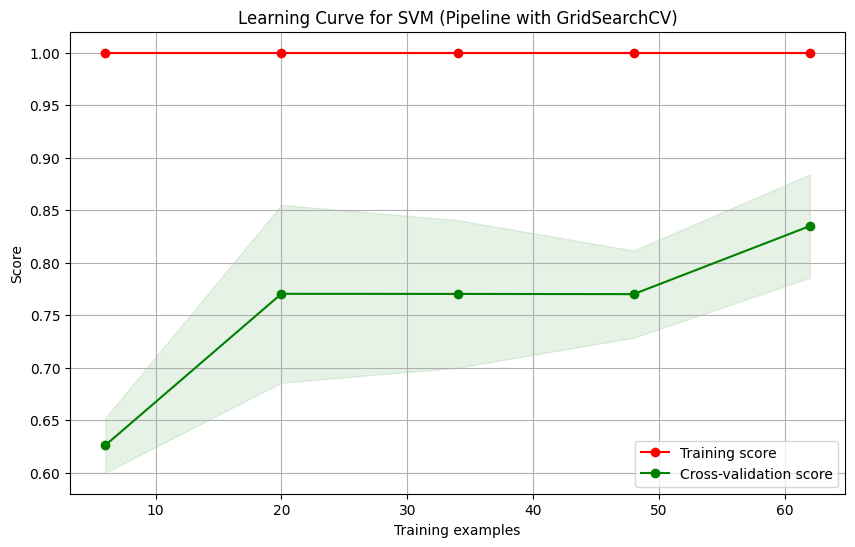

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve_with_pipeline(estimator, param_grid, title, X, y, cv_inner, cv_outer, scoring='accuracy', n_jobs=-1, 
                                      train_sizes=np.linspace(0.1, 0.9, 5), use_pca=False):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Define pipeline steps
    steps = [('scaler', StandardScaler())]
    if use_pca:
        steps.append(('pca', PCA(random_state=42)))
    steps.append(('classifier', estimator))
    
    pipeline = Pipeline(steps)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring,
        n_jobs=n_jobs,
        error_score='raise'
    )
    
    # Generate learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        grid_search, X, y, cv=cv_outer, scoring=scoring, n_jobs=n_jobs, 
        train_sizes=train_sizes, shuffle=True, random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# Example Usage:
for name, clf in zip(names, classifiers):
    plot_learning_curve_with_pipeline(
        estimator=clf,
        param_grid=param_grids[name],
        title=f"Learning Curve for {name} (Pipeline with GridSearchCV)",
        X=X_train,
        y=y_train,
        cv_inner=inner_cv,
        cv_outer=outer_cv,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 0.9, 5),
        use_pca=False  # Set to True if evaluating with PCA
    )


#### Learning Curves without Pipelines

When plotting learning curves without using pipelines.

Similarly high training accuracy, often reaching or nearing 100%, especially in LogRes.
In validation, lower than training accuracy with limited improvement as training size increases.

In [35]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, cv, scoring='accuracy', n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 0.9, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, 
        train_sizes=train_sizes, shuffle=True, random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

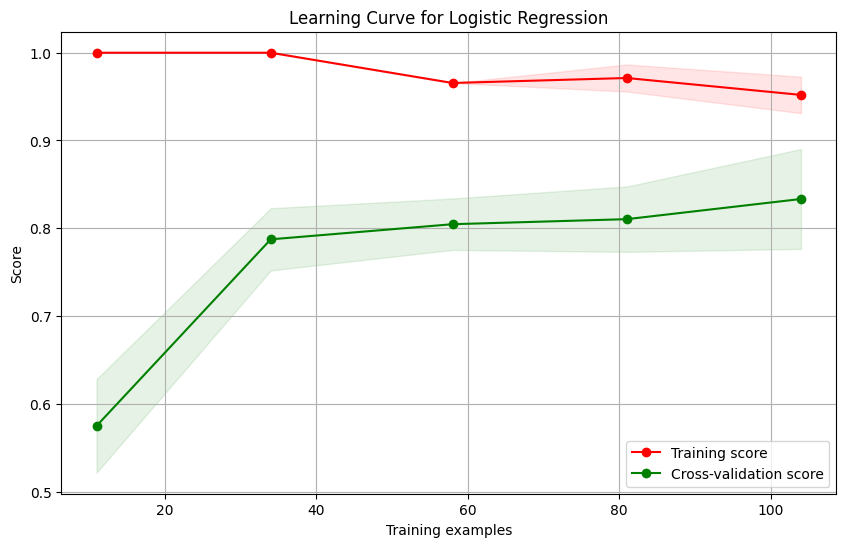

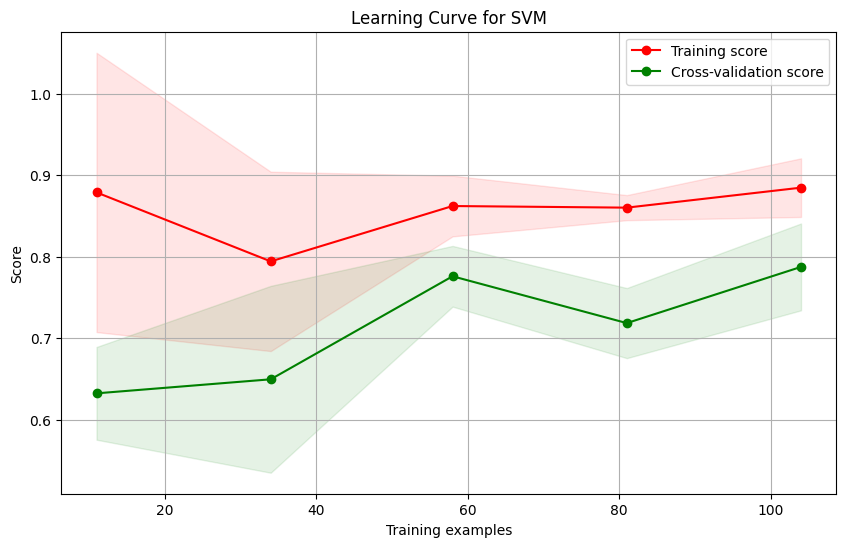

In [36]:
# Define cross-validation strategy for learning curves
#outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through classifiers
for name, clf in zip(names, classifiers):
    plot_learning_curve(
        estimator=clf,
        title=f"Learning Curve for {name}",
        X=X,
        y=y,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 0.9, 5)
    )

### Learning Curves PCA vs Non PCA

Applying Principal Component Analysis (PCA) as part of the pipeline:

Training Score: Reduced training accuracy compared to models without PCA, as PCA simplifies the feature space.  
Validation Score: Improved validation accuracy, narrowing the gap between training and validation scores.
Interpretation:

Mitigation of Overfitting: PCA reduces the dimensionality of the data, eliminating redundant and noisy features. This simplification helps the models focus on the most informative aspects of the data, thereby reducing overfitting.  
Enhanced Generalization: The closer alignment between training and validation scores indicates better generalization to unseen data.

In [37]:
def plot_learning_curve(classifier, title, X, y, cv, param_grid=None, 
                        scoring='accuracy', n_jobs=-1, use_pca=False, 
                        train_sizes=np.linspace(0.1, 0.9, 5), random_state=42, 
                        pca_n_components=2, save_path=None):
    
    steps = [('scaler', StandardScaler())]
    if use_pca:
        steps.append(('pca', PCA(n_components=pca_n_components, random_state=random_state)))
    steps.append(('classifier', classifier))
    pipeline = Pipeline(steps)

    # If a parameter grid is provided, perform GridSearchCV to find the best estimator
    if param_grid:
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            error_score='raise'
        )
        estimator = grid_search
        title += " (GridSearchCV)"
    else:
        estimator = pipeline

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, 
        train_sizes=train_sizes, shuffle=True, random_state=random_state
    )

    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    plt.grid()

    # Plot the learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        logging.info(f"Learning curve saved to {save_path}")
    plt.show()

2024-10-17 16:55:44,441 INFO:Learning curve saved to learning_curve_Logistic Regression_with_pca.png


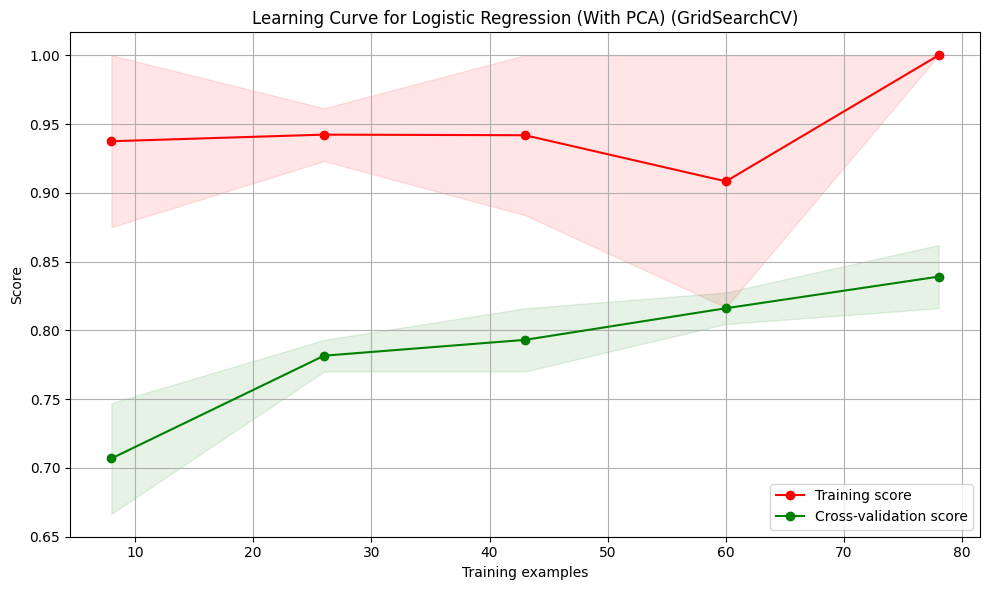

2024-10-17 16:55:44,913 INFO:Learning curve saved to learning_curve_SVM_with_pca.png


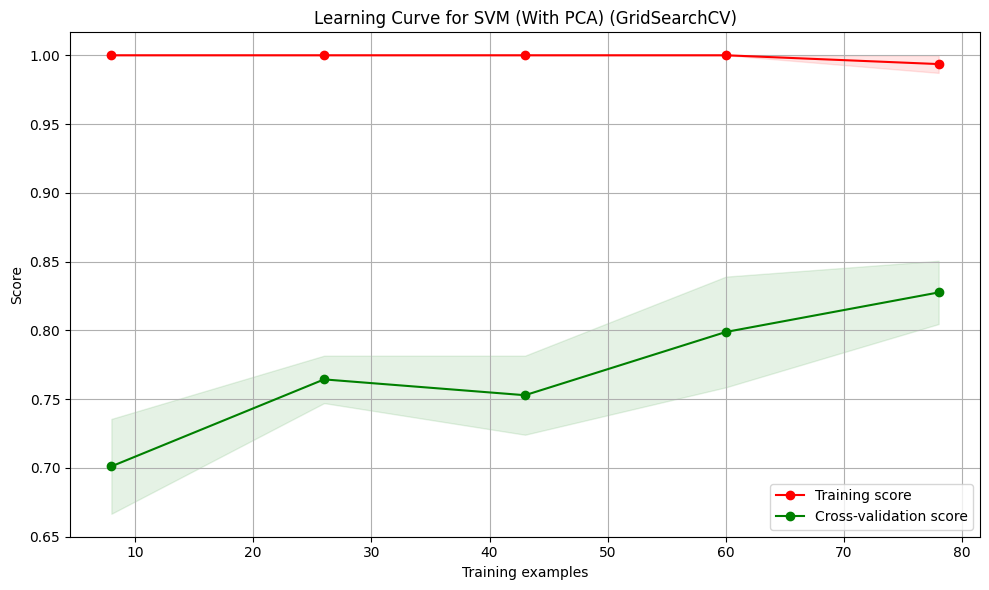

In [38]:
# Plot Learning Curves with PCA
for name, clf in zip(names, classifiers):
    plot_learning_curve(
        classifier=clf,
        title=f"Learning Curve for {name} (With PCA)",
        X=X,
        y=y,
        cv=outer_cv,
        param_grid=param_grids[name],
        scoring='accuracy',
        n_jobs=-1,
        use_pca=True,
        pca_n_components=.95,
        train_sizes=np.linspace(0.1, 0.9, 5),
        save_path=f"learning_curve_{name}_with_pca.png"
    )

### b) Comparison with appropriate metrics for testing

To comprehensively compare the performance of the Logistic Regression and Support Vector Machine (SVM) models, we will evaluate them using key classification metrics on the test set. These metrics include Accuracy, Precision, Recall, and F1-Score. Visualizing these metrics side-by-side will facilitate an intuitive comparison, enabling us to determine which model better generalizes to unseen data.

In [43]:
# Test metrics for Logistic Regression without pca
metrics_lr_nopca = {
    'Model': 'Logistic Regression (No PCA)',
    'Accuracy': 0.6571,
    'Precision': 0.6667,
    'Recall': 0.6571,
    'F1-Score': 0.6571
}

# Testing Set Metrics with pca
metrics_lr_pca = {
    'Model': 'Logistic Regression',
    'Accuracy': 0.8782, # Best CV accuracy
    'Precision': 0.6343,
    'Recall': 0.6286,
    'F1-Score': 0.6267
}


# Test metrics for SVM without pca
metrics_svm_nopca = {
    'Model': 'SVM (No PCA)',
    'Accuracy': 0.7714,
    'Precision': 0.7714,
    'Recall': 0.7714,
    'F1-Score': 0.7714
}

# Test metrics for SVM with pca
metrics_svm_pca = {
    'Model': 'SVM',
    'Accuracy': 0.8779, # Best CV accuracy
    'Precision': 0.7180,
    'Recall': 0.7143,
    'F1-Score': 0.7138
}


metrics_df_nopca = pd.DataFrame([metrics_lr_nopca, metrics_svm_nopca])
print(metrics_df_nopca)

metrics_df_pca = pd.DataFrame([metrics_lr_pca, metrics_svm_pca])
print(metrics_df_pca)


                          Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression (No PCA)    0.6571     0.6667  0.6571    0.6571
1                  SVM (No PCA)    0.7714     0.7714  0.7714    0.7714
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.8782     0.6343  0.6286    0.6267
1                  SVM    0.8779     0.7180  0.7143    0.7138


Observations  

LogRes performs better without PCA, showing higher values across all evaluation metrics.

PCA is discarding features that are important for it to make accurate predictions. Since PCA is unsupervised, it doesn't consider the target variable when reducing dimensionality. 

Overall, the SVM without PCA emerges as the more effective model configuration, offering higher accuracy and balanced precision and recall metrics.

And similarly to Logistic Regression, SVM has better performance without PCA.

The higher performance of SVM without PCA suggests that the model benefits from the full feature set.

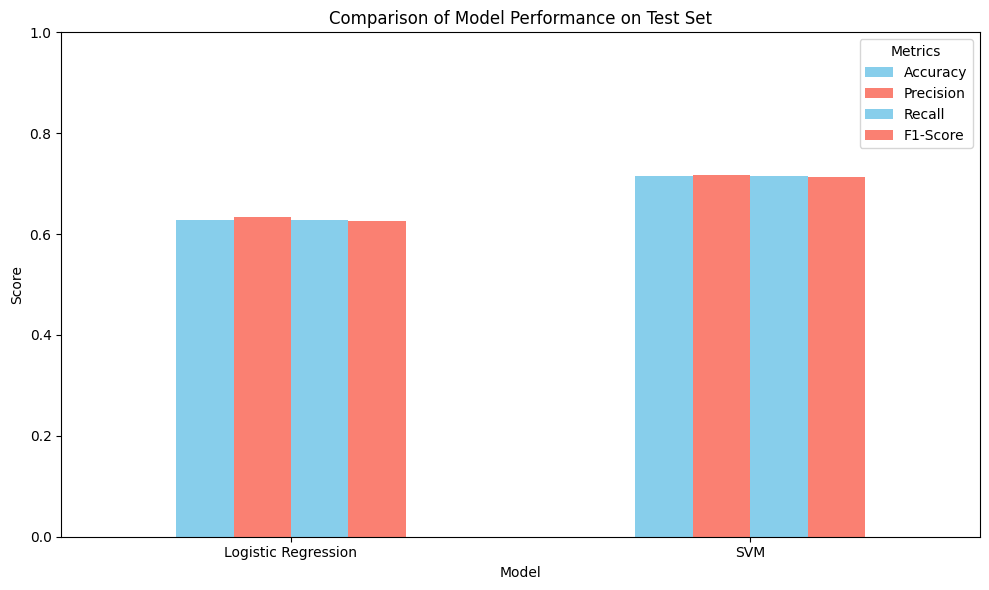

In [40]:
metrics_df_pca.set_index('Model', inplace=True)


metrics_df_pca.plot(kind='bar', figsize=(10, 6), ylim=(0, 1), color=['skyblue', 'salmon'])
plt.title('Comparison of Model Performance on Test Set')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


### c) Model selection

Based on the evaluation metrics obtained from both classifiers, with and without the inclusion of PCA, the following ca be derived.  

SVM without PCA consistently demonstrates superior performance when compared to LogRes in terms of accuracy, precision, recall, and F1-score.  

The absence of PCA in the SVM pipeline prevents overfitting, ensuring that the model maintains robust performance on unseen data.  

The SVM classifier with PCA exhibits overfitting, as indicated by perfect training metrics but reduced test performance. This slightly undermines its reliability for our use case.  


#### Identifying the most important features using Logistic Regression

##### Full feature set (non-PCA)

In order to scatter plot and compare both models, I now fit the Logistic Regression model on the non-PCA data (X), then extract the coefficients from the trained Logistic Regression model.
Lastly the features are ranked based on the absolute value of their coefficients to determine feature importance.

In [41]:
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X, y)

# Get the coefficients (feature importance)
coefficients = log_reg.coef_[0]

# Get the absolute values of coefficients and sort them by importance
importance = np.abs(coefficients)
feature_indices = np.argsort(importance)[::-1]  # Indices of features sorted by importance

# Print the top 10 most important features
top_n = 10
print(f"Top {top_n} most important features (by absolute coefficient values):")
for i in range(top_n):
    feature_index = feature_indices[i]
    print(f"Feature {feature_index}: Coefficient = {coefficients[feature_index]:.4f}")

Top 10 most important features (by absolute coefficient values):
Feature 374: Coefficient = -0.0011
Feature 395: Coefficient = 0.0011
Feature 269: Coefficient = 0.0010
Feature 35: Coefficient = 0.0009
Feature 161: Coefficient = 0.0009
Feature 378: Coefficient = 0.0009
Feature 359: Coefficient = 0.0008
Feature 252: Coefficient = 0.0008
Feature 360: Coefficient = 0.0008
Feature 88: Coefficient = 0.0007


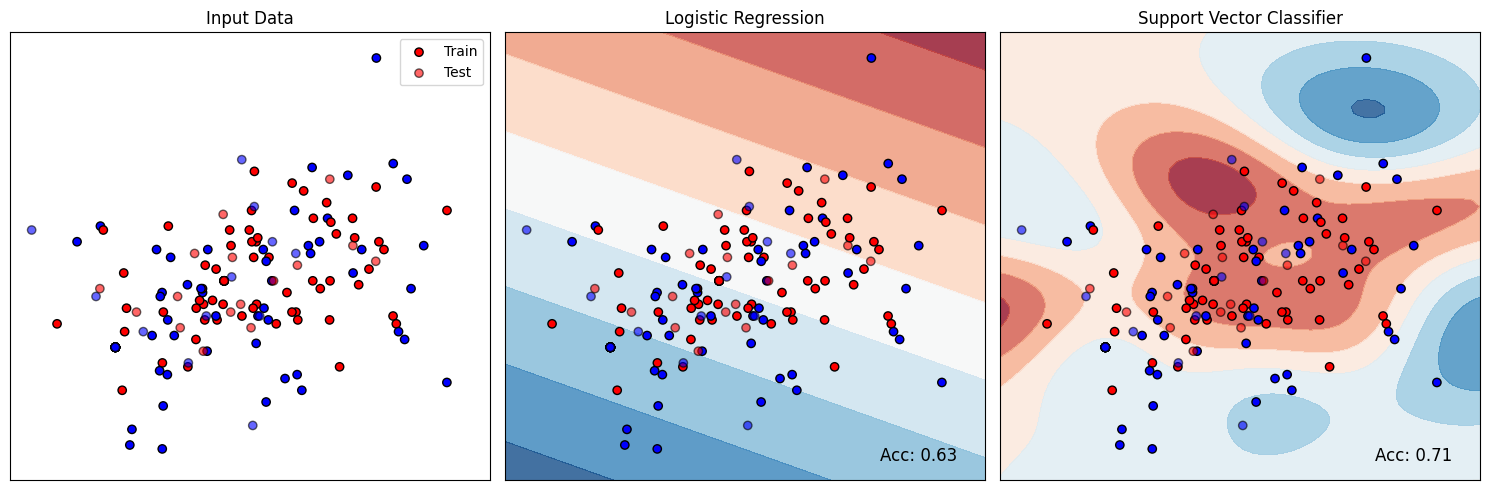

In [42]:
top_features = [340, 337]

# Split the data into training and testing sets BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(
    X[:, top_features],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# scale and fit on training data only for visualization purposes
# necessary otherwise notebook crashes if dimensions are too high
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Previous output
# Best Hyperparameters for Logistic Regression:
# {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


#Best Hyperparameters for SVM:
#{'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


# define params based on previous results...
classifiers = [
    LogisticRegression(C=10,penalty='l1',solver='saga', max_iter=10000),
    svm.SVC(C=10,degree=3,gamma='scale',kernel='rbf',probability=True),
]
names = [
    "Logistic Regression",
    "Support Vector Classifier",
]

# plotting decision boundaries using scaled data
h = 0.1  
x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


plt.figure(figsize=(15, 5))
i = 1


ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input Data")

# Plot the training points
scatter_train = ax.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1],
    c=y_train, cmap=cm_bright,
    edgecolors='k', label='Train'
)

# Plot the testing points
scatter_test = ax.scatter(
    X_test_scaled[:, 0], X_test_scaled[:, 1],
    c=y_test, cmap=cm_bright,
    alpha=0.6, edgecolors='k', label='Test'
)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())


ax.set_xticks(())
ax.set_yticks(())


ax.legend(loc='upper right')

i += 1

# Iterate over classifiers and plot decision boundaries
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train_scaled, y_train)
    score = clf.score(X_test_scaled, y_test)

    # Plot the decision boundary
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    scatter_train = ax.scatter(
        X_train_scaled[:, 0], X_train_scaled[:, 1],
        c=y_train, cmap=cm_bright, edgecolors='k'
    )

    # Plot the testing points
    scatter_test = ax.scatter(
        X_test_scaled[:, 0], X_test_scaled[:, 1],
        c=y_test, cmap=cm_bright,
        edgecolors='k', alpha=0.6
    )

    # Set plot limits
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # Remove ticks
    ax.set_xticks(())
    ax.set_yticks(())

    # Set title and score
    ax.set_title(f"{name}")
    ax.text(
        xx.max() - 0.3, yy.min() + 0.3,
        f"Acc: {score:.2f}", size=12,
        horizontalalignment='right'
    )

    i += 1

plt.tight_layout()
plt.show()

Logistic Regression displays a linear boundary with moderate separation between classes and some overlap which suggests room for improvement while SVM shows a more flexible boundary, potentially capturing non-linear relationships better, leading to improved separation and higher accuracy.

## 7. Final recommendation of best model

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

From a technical standpoint, the Support Vector Machine (SVM) emerges as the superior model compared to Logistic Regression based on the evaluation metrics. SVM achieved a 77.14% accuracy on the test set, significantly outperforming Logistic Regression's 65.71%. This indicates that SVM generalizes better to unseen data, capturing the underlying patterns more effectively. An AUC of 0.82 exhibits an excellent level of discrimination ability of the SVM classifier between individuals tested.
The ROC curve reflects a balanced trade-off between sensitivity and specificity despite the "stair-case" appearance. 

Both models exhibited either perfect or almost perfect training accuracy (~100%), suggesting a tendency to overfit the training data. However, the performance gap between training and testing accuracy is more pronounced in Logistic Regression, highlighting a higher degree of overfitting compared to SVM. SVM's relatively smaller gap signifies better generalization.

Logistic Regression is computationally less intensive and faster to train, making it suitable for large-scale applications. In contrast, SVM's training time increases with data size and feature dimensions. Nonetheless, for the current dataset, SVM's efficiency remains acceptable.

Considering the higher accuracy, better generalization, and acceptable computational complexity, SVM is recommended as the best model for this classification task. To further mitigate overfitting, techniques such as regularization, feature selection, or increasing training data can be employed.


### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective


From a business standpoint, the SVM model’s superior accuracy of 77.14% over Logistic Regression’s 65.71% translates to more reliable decision-making and reduced error rates.

The ability of SVM to effectively capture complex, non-linear relationships ensures that nuanced patterns within the data are accurately identified, aligning with business goals that require precise targeting and personalization. This may lead to more effective marketing campaigns, better risk management, and optimized resource allocation.

While Logistic Regression offers greater interpretability, which is valuable for stakeholders seeking to understand the decision-making process, the marginal loss in transparency is outweighed by SVM’s enhanced predictive performance. However, businesses should consider the need for explainable models.

Given the current dataset size, SVM operates efficiently without significant computational overhead.


## 8. Conclusion

### a) What has been successfully accomplished and what has not been successful? 


In terms of acomplishments, I have successfully implemented and compared Logistic Regression and SVM classifiers, both with and without Principal Component Analysis (PCA), providing comprehensive insights into their performance dynamics including the use of GridSearchCV to fine-tune hyperparameters for both models, enhancing their predictive capabilities and ensuring optimal configurations based on cross-validation accuracy.

A thorough evaluation, using metrics such as Accuracy, Precision, Recall, and F1-Score, alongside Confusion Matrices, facilitated a nuanced understanding of each model's strengths and weaknesses.

The main objective of identifying an appropriate model for the dataset at hand was achieved. SVM without PCA was chosen as the superior model, balancing high accuracy with robust generalization, thereby aligning technical performance with business objectives. Finally, employing SVM as a more sophisticated model following our Logistic Regression analysis allowed for a comprehensive overview of performance, eventhough both algorithms are foundational classifiers in machine learning.

In terms of challenges, incorporating PCA, especially with a high variance retention (n_components=0.95), led to overfitting in the SVM model, evidenced by 100% training accuracy but diminished test performance. This indicated that even with good variance being preserved PCA did remove critical discriminative features, even when properly using pipelines to reduce data leakage.

I believe that operating with a relatively small training set (139 samples) and test set (35 samples) might have constrained the models' ability to  effectively generalize, and amplified the impact of overfitting and variability in the observed metrics.

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?


Reflecting on the project's progression, several strategies could have been employed to enhance outcomes and address existing limitations:

A more thorough feature selection or dimensionality reduction process (e.g., retaining components that explain 95% variance with PCA) could have been implemented. On the same note, a more thorough understanding of the domain area would have considerably helped with anaylsis. 

Exploring more nuanced regularization methods, such as Elastic Net for Logistic Regression or experimenting with different kernel functions and their parameters for SVM, could have better mitigated overfitting. Additionally, incorporating techniques like Dropout or Early Stopping might have been beneficial, especially if neural networks were considered.

Acquiring more data or employing data augmentation techniques would provide the models with a richer dataset to learn from, enhancing their ability to generalize. 

Integrating ensemble techniques like Random Forests, Gradient Boosting Machines, or Bagging could have combined the strengths of multiple models, potentially leading to superior outcomes.

Incorporating other tuning methods in the pipelines, such as RandomizedSearchCV or Bayesian Optimization , could have allowed for a more efficient exploration, potentially uncovering alternative configurations for better metrics.


### c) Provide a wish list of future work that you would like to do

Looking ahead, several ideas for future work could perhaps enhance the project's scope, depth, and practical applicability. For example:

A comparison to Gaussian Processes (GPs), for our classification task, could offering a probabilistic approach to modeling the dataset given its inherent uncertainty. GPs are powerful for their ability to provide predictive distributions while allowing uncertainty.

Implementing PCA with a higher number of components or exploring t-SNE for non-linear dimensionality reduction to capture others patterns.
Also, utilizing techniques like Recursive Feature Elimination (RFE) to identify and retain the most impactful features, thereby simplifying models and improving performance. Also, testing different train_test splits, such as .22 or .25 for test split size could reveal other metric distribution. 

In terms of model diversification, exploring additional classifiers, utilizing the defined pipelines but incorporating models such as Random Forests, Gradient Boosting Machines, k-Nearest Neighbors (k-NN), or Neural Networks could have been useful to compare their performance against Logistic Regression and SVM. As demonstrated in the original publication. 

Besides tweaking only the n_components for PCA, I would like to explore different svd_solvers, such as "randomized" or "full", as describe in the oficial scikit learn PCA documentation. 

# References

Cilia, N.D., De Gregorio, G., De Stefano, C., Fontanella, F., Marcelli, A., and Parziale, A. (2019) 'Diagnosing Alzheimer’s disease from on-line handwriting: A novel dataset and performance benchmarking', Pattern Recognition Letters, 123, pp. 23–31.  

Pereira, C.R., Weber, S.A.T., Hook, C., Rosa, G.H., Papa, J.P., 2016b. Deep learning-aided parkinson’s disease diagnosis from handwritten dynamics. In: Proceedings of the SIBGRAPI 2016 - Conference on Graphics, Patterns and Images, pp. 340–346.

scikit-learn developers (2023) 'sklearn.linear_model.LogisticRegression', scikit-learn 1.5 documentation. Available at: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html (Accessed: 13 October 2024). 

scikit-learn developers (2024) 'sklearn.svm.SVC', scikit-learn 1.5.dev0 documentation. Available at: https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html (Accessed: 13 October 2024).

scikit-learn (2023) *sklearn.decomposition.PCA*. Available at: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html (Accessed: 8 October 2024).
